# Core v2 — Otimização de Modelos com Algoritmo Genético (PyGAD)

Este notebook é uma evolução do `core.ipynb`.  
Objetivo: **otimizar os hiperparâmetros do RandomForestClassifier** utilizando um **Algoritmo Genético (PyGAD)** e comparar os resultados com o modelo baseline.

ETAPA 1 - Importação das bibliotecas

In [64]:
import numpy as np
import re
import pygad
import os
import pandas as pd
import matplotlib.pyplot as plt
from textwrap import dedent
from dotenv import load_dotenv
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix)
from openai import OpenAI
from fpdf import FPDF

load_dotenv()
SEED = 25
CV_SPLITS = 5
np.random.seed(SEED)

# Carregar dataset
X, y = load_breast_cancer(return_X_y=True)
# Configuração da validação estratificada
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=SEED)

In [ ]:
def avaliar_modelo(modelo, X, y, cv_splits=5, seed=25, threshold=0.5):
    
    cv_local = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed)

    # Probabilidade da classe positiva (OOF)
    y_prob = cross_val_predict(
        modelo, X, y, cv=cv_local, method="predict_proba", n_jobs=-1
    )[:, 1]

    # Classe prevista a partir do limiar definido
    y_pred = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0     # recall da classe positiva
    esp  = tn / (tn + fp) if (tn + fp) > 0 else 0.0     # especificidade

    metrics = {
        "accuracy":      accuracy_score(y, y_pred),
        "precision":     precision_score(y, y_pred),
        "recall":        recall_score(y, y_pred),  
        "f1":            f1_score(y, y_pred),
        "auc":           roc_auc_score(y, y_prob),
        "sensibilidade": sens,
        "especificidade": esp,
    }
    return metrics

In [ ]:
# Função fitness: recebe genes = hiperparâmetros e retorna F1 médio (CV=5)
def fitness_func_factory(X, y, cv, random_state=25):

    def fitness_func(ga_instance, solution, solution_idx):
        n_estimators = int(solution[0])
        max_depth = int(solution[1])
        min_samples_split = int(solution[2])

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=random_state
        )
        scores = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1)
        return float(np.mean(scores))
    return fitness_func

In [67]:
def rodar_ga(exp_nome, gene_space, num_generations, num_parents_mating,
             sol_per_pop, mutation_probability, crossover_probability,
             random_seed=25, parent_selection_type="rws",
             crossover_type="single_point", mutation_type="random"):
  
    ga = pygad.GA(
        num_generations=num_generations,
        num_parents_mating=num_parents_mating,
        fitness_func=fitness_func_factory(X, y, cv, random_state=SEED),
        sol_per_pop=sol_per_pop,
        num_genes=len(gene_space),
        gene_space=gene_space,
        mutation_probability=mutation_probability,
        crossover_probability=crossover_probability,
        allow_duplicate_genes=False,
        random_seed=random_seed,
        parent_selection_type=parent_selection_type,
        crossover_type=crossover_type,
        mutation_type=mutation_type,
    )
    print(f"\n[GA] Rodando {exp_nome} ...")
    ga.run()
    best_solution, best_fitness, _ = ga.best_solution()
    print(f"[GA] {exp_nome} - melhores hiperparâmetros:", best_solution)
    print(f"[GA] {exp_nome} - melhor F1 médio (CV={CV_SPLITS}): {best_fitness:.4f}")
    return best_solution, float(best_fitness), ga

In [68]:
def salvar_grafico_barras(labels, scores, title, fname, ylim=None):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, scores)
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                 f"{score:.4f}", ha="center", va="bottom", fontsize=10, fontweight="bold")
    plt.title(title)
    plt.ylabel("F1-score médio (CV=5)")
    if ylim:
        plt.ylim(*ylim)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.close()

In [69]:
def salvar_grafico_linha(labels, scores, title, fname, ylim=None):
    plt.figure(figsize=(8, 5))
    plt.plot(labels, scores, marker="o", linestyle="-", linewidth=2)
    for i, score in enumerate(scores):
        plt.text(i, score + (0.0005 if ylim else 0.0), f"{score:.4f}", ha="center", fontsize=10, fontweight="bold")
    plt.title(title)
    plt.ylabel("F1-score médio (CV=5)")
    if ylim:
        plt.ylim(*ylim)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.close()

In [70]:
baseline_model = RandomForestClassifier(random_state=SEED)
baseline_metrics = avaliar_modelo(baseline_model, X, y, cv_splits=CV_SPLITS, seed=SEED)
baseline_f1 = baseline_metrics["f1"]
print("\n=== Baseline (RandomForest default) ===")
print(baseline_metrics)


=== Baseline (RandomForest default) ===
{'accuracy': 0.9578207381370826, 'precision': 0.9586776859504132, 'recall': 0.9747899159663865, 'f1': 0.9666666666666667, 'auc': 0.9896279266423551, 'sensibilidade': np.float64(0.9747899159663865), 'especificidade': np.float64(0.9292452830188679)}


In [71]:
# Espaço de busca (limites de cada hiperparâmetro)
gene_space = [
    range(50, 301),   # n_estimators
    range(1, 31),     # max_depth
    range(2, 21)      # min_samples_split
]


# Experimento 1 = GA padrão


In [72]:
best_solution1, best_f1_1, ga1 = rodar_ga(
    exp_nome="Exp1 (pop=16, gen=12, mut=0.15)",
    gene_space=gene_space,
    num_generations=12,
    num_parents_mating=6,
    sol_per_pop=16,
    mutation_probability=0.15,
    crossover_probability=0.9,
    random_seed=SEED,
    parent_selection_type="rws",       
    crossover_type="single_point",
    mutation_type="random"
)

best_model1 = RandomForestClassifier(
    n_estimators=int(best_solution1[0]),
    max_depth=int(best_solution1[1]),
    min_samples_split=int(best_solution1[2]),
    random_state=SEED
)
metrics_exp1 = avaliar_modelo(best_model1, X, y, cv_splits=CV_SPLITS, seed=SEED)
print("Exp1 - métricas:", metrics_exp1)


[GA] Rodando Exp1 (pop=16, gen=12, mut=0.15) ...
[GA] Exp1 (pop=16, gen=12, mut=0.15) - melhores hiperparâmetros: [74. 19.  5.]
[GA] Exp1 (pop=16, gen=12, mut=0.15) - melhor F1 médio (CV=5): 0.9710
Exp1 - métricas: {'accuracy': 0.9630931458699473, 'precision': 0.9615384615384616, 'recall': 0.9803921568627451, 'f1': 0.970873786407767, 'auc': 0.9893108186670895, 'sensibilidade': np.float64(0.9803921568627451), 'especificidade': np.float64(0.9339622641509434)}


# Experimento 2 = População maior e mais gerações

In [73]:
best_solution2, best_f1_2, ga2 = rodar_ga(
    exp_nome="Exp2 (pop=20, gen=20, mut=0.20)",
    gene_space=gene_space,
    num_generations=20,
    num_parents_mating=8,
    sol_per_pop=20,
    mutation_probability=0.20,
    crossover_probability=0.9,
    random_seed=SEED,
    parent_selection_type="rws",
    crossover_type="single_point",
    mutation_type="random"
)

best_model2 = RandomForestClassifier(
    n_estimators=int(best_solution2[0]),
    max_depth=int(best_solution2[1]),
    min_samples_split=int(best_solution2[2]),
    random_state=SEED
)
metrics_exp2 = avaliar_modelo(best_model2, X, y, cv_splits=CV_SPLITS, seed=SEED)
print("Exp2 - métricas:", metrics_exp2)


[GA] Rodando Exp2 (pop=20, gen=20, mut=0.20) ...
[GA] Exp2 (pop=20, gen=20, mut=0.20) - melhores hiperparâmetros: [50.  5.  3.]
[GA] Exp2 (pop=20, gen=20, mut=0.20) - melhor F1 médio (CV=5): 0.9710
Exp2 - métricas: {'accuracy': 0.9630931458699473, 'precision': 0.9615384615384616, 'recall': 0.9803921568627451, 'f1': 0.970873786407767, 'auc': 0.9896345330585063, 'sensibilidade': np.float64(0.9803921568627451), 'especificidade': np.float64(0.9339622641509434)}


# Experimento 3 = População menor e mutação baixa

In [74]:
best_solution3, best_f1_3, ga3 = rodar_ga(
    exp_nome="Exp3 (pop=10, gen=10, mut=0.10)",
    gene_space=gene_space,
    num_generations=10,
    num_parents_mating=4,
    sol_per_pop=10,
    mutation_probability=0.10,
    crossover_probability=0.8,
    random_seed=SEED,
    parent_selection_type="rws",
    crossover_type="single_point",
    mutation_type="random"
)

best_model3 = RandomForestClassifier(
    n_estimators=int(best_solution3[0]),
    max_depth=int(best_solution3[1]),
    min_samples_split=int(best_solution3[2]),
    random_state=SEED
)
metrics_exp3 = avaliar_modelo(best_model3, X, y, cv_splits=CV_SPLITS, seed=SEED)
print("Exp3 - métricas:", metrics_exp3)


[GA] Rodando Exp3 (pop=10, gen=10, mut=0.10) ...
[GA] Exp3 (pop=10, gen=10, mut=0.10) - melhores hiperparâmetros: [64. 11.  5.]
[GA] Exp3 (pop=10, gen=10, mut=0.10) - melhor F1 médio (CV=5): 0.9710
Exp3 - métricas: {'accuracy': 0.9630931458699473, 'precision': 0.9615384615384616, 'recall': 0.9803921568627451, 'f1': 0.970873786407767, 'auc': 0.9892447545055758, 'sensibilidade': np.float64(0.9803921568627451), 'especificidade': np.float64(0.9339622641509434)}


# Tabela comparativa (todas as métricas)

In [75]:
linhas = [
    ("Baseline (RF default)", baseline_metrics),
    ("GA - Exp1 (pop=16, gen=12, mut=0.15)", metrics_exp1),
    ("GA - Exp2 (pop=20, gen=20, mut=0.20)", metrics_exp2),
    ("GA - Exp3 (pop=10, gen=10, mut=0.10)", metrics_exp3),
]

col_order = ["accuracy","precision","recall","sensibilidade","especificidade","f1","auc"]
tabela = pd.DataFrame(
    [{**m, "Configuração": nome} for nome, m in linhas]
)[["Configuração"] + col_order].round(4)

print("\n=== Comparação de Métricas (OOF / CV=5) ===")
print(tabela.to_string(index=False))

# Salvar CSV da tabela
tabela.to_csv("metricas_completas.csv", index=False)
print("\nArquivo salvo: metricas_completas.csv")


=== Comparação de Métricas (OOF / CV=5) ===
                        Configuração  accuracy  precision  recall  sensibilidade  especificidade     f1    auc
               Baseline (RF default)    0.9578     0.9587  0.9748         0.9748          0.9292 0.9667 0.9896
GA - Exp1 (pop=16, gen=12, mut=0.15)    0.9631     0.9615  0.9804         0.9804          0.9340 0.9709 0.9893
GA - Exp2 (pop=20, gen=20, mut=0.20)    0.9631     0.9615  0.9804         0.9804          0.9340 0.9709 0.9896
GA - Exp3 (pop=10, gen=10, mut=0.10)    0.9631     0.9615  0.9804         0.9804          0.9340 0.9709 0.9892

Arquivo salvo: metricas_completas.csv


# Gráficos de comparação de F1

In [76]:
labels = [
    "Baseline",
    "GA Exp1\n(pop=16, gen=12, mut=0.15)",
    "GA Exp2\n(pop=20, gen=20, mut=0.20)",
    "GA Exp3\n(pop=10, gen=10, mut=0.10)"
]
scores = [baseline_metrics["f1"], metrics_exp1["f1"], metrics_exp2["f1"], metrics_exp3["f1"]]

salvar_grafico_barras(
    labels, scores,
    title="Comparação do F1-score: Baseline vs GA Experimentos",
    fname="plot_f1_barras.png",
    ylim=None  # coloque algo como (0.96, 0.98) se quiser travar eixo
)
salvar_grafico_linha(
    ["Baseline","GA Exp1","GA Exp2","GA Exp3"], scores,
    title="Evolução do F1-score: Baseline → GA Experimentos",
    fname="plot_f1_linha.png",
    ylim=None
)
print("Gráficos salvos: plot_f1_barras.png, plot_f1_linha.png")

Gráficos salvos: plot_f1_barras.png, plot_f1_linha.png


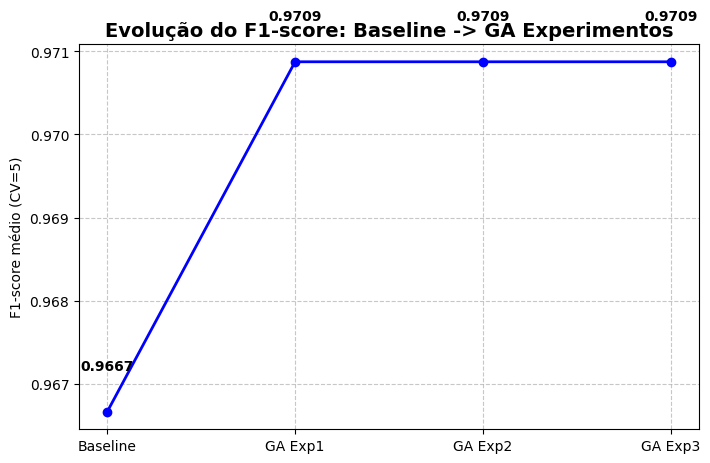

In [77]:
# Gráfico de linha (usando as métricas calculadas)
labels_simple = ["Baseline", "GA Exp1", "GA Exp2", "GA Exp3"]
scores_simple = [
    baseline_metrics["f1"],
    metrics_exp1["f1"],
    metrics_exp2["f1"],
    metrics_exp3["f1"],
]

plt.figure(figsize=(8,5))
plt.plot(labels_simple, scores_simple, marker="o", linestyle="-", color="blue", linewidth=2)
for i, score in enumerate(scores_simple):
    plt.text(i, score + 0.0005, f"{score:.4f}", ha="center", fontsize=10, fontweight="bold")
plt.title("Evolução do F1-score: Baseline -> GA Experimentos", fontsize=14, fontweight="bold")
plt.ylabel("F1-score médio (CV=5)")
# Ajuste o ylim conforme seus valores (ou comente a linha abaixo)
# plt.ylim(0.96, 0.98)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


In [ ]:
from textwrap import dedent
import re, os
try:
    from openai import OpenAI
except Exception:
    pass

def gerar_explicacao(hiperparams, baseline_f1, best_f1):
    """
    Gera um texto clínico curto, objetivo e SEM frases genéricas.
    Formato obrigatório com duas seções e 3 recomendações.
    """
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        return None
    client = OpenAI(api_key=api_key)

    melhoria_pct = ((best_f1 - baseline_f1) / baseline_f1) * 100.0
    prompt = dedent(f"""
    Atue como um(a) mastologista escrevendo para médicos. Responda em até 180–220 palavras,
    em português, com linguagem assertiva e sem generalidades. NÃO use frases como:
    "parece que", "você está compartilhando", "se você quiser", "possivelmente".

    DADOS:
    - Modelo: RandomForest otimizado por Algoritmo Genético
    - Hiperparâmetros: n_estimators={int(hiperparams[0])}, max_depth={int(hiperparams[1])}, min_samples_split={int(hiperparams[2])}
    - F1 baseline: {baseline_f1:.4f}
    - F1 otimizado: {best_f1:.4f}
    - Melhoria percentual: {melhoria_pct:.2f}%

    FORMATO OBRIGATÓRIO:
    **Explicação técnica resumida:** (2–4 frases) defina F1 de forma objetiva, descreva como esses hiperparâmetros impactam
    sobreajuste vs. viés e por que houve (ou não) ganho real.

    **Interpretação na prática clínica:** (3–5 frases) explicite impacto em falsos negativos/positivos, triagem e confirmação.
    Foque em segurança do paciente e priorize sensibilidade quando aplicável.

    **Recomendações:** (3 itens curtos e concretos) p.ex.: calibrar limiar de decisão; revisar amostras discordantes; validar prospectivamente.

    **Observação:** Validação com dados clínicos reais é mandatória antes de uso assistencial.
    """)

    try:
        r = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "Você é um(a) mastologista. Seja conciso, técnico e clínico."},
                {"role": "user", "content": prompt},
            ],
            temperature=0.2,
            top_p=0.9,
            max_tokens=500,
            presence_penalty=0.0,
            frequency_penalty=0.2,
        )
        return r.choices[0].message.content.strip()
    except Exception as e:
        print("Erro LLM gerar_explicacao:", e)
        return None

In [79]:
def gerar_explicacao_com_texto(hiperparams, metricas, relato_clinico):
    """
    Integra métricas + relato. Gera texto clínico estruturado com recomendações.
    """
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        return None
    client = OpenAI(api_key=api_key)

    sens = metricas.get("sensibilidade", 0.0)
    esp  = metricas.get("especificidade", 0.0)
    f1   = metricas.get("f1", 0.0)
    auc  = metricas.get("auc", 0.0)

    prompt = dedent(f"""
    Atue como mastologista. Em 180–230 palavras, gere análise clínica objetiva do caso,
    sem frases genéricas. Não use "parece que" ou "talvez".

    HIPERPARÂMETROS: n_estimators={int(hiperparams[0])}, max_depth={int(hiperparams[1])}, min_samples_split={int(hiperparams[2])}
    MÉTRICAS: Sensibilidade={sens:.3f}, Especificidade={esp:.3f}, F1={f1:.3f}, AUC={auc:.3f}

    RELATO:
    \"\"\"{relato_clinico}\"\"\"

    Estruture assim:
    **Análise combinada:** relacione as métricas ao risco do caso (ênfase em sensibilidade para minimizar FN).
    **Correlação com o texto clínico:** aponte sinais do relato que sustentam o risco.
    **Probabilidade diagnóstica:** descreva como sensibilidade/especificidade e AUC modulam a confiança.
    **Recomendações:** 3–4 itens práticos (p.ex., mamografia complementar, US, core biopsy, revisão radiológica cega).
    **Observação:** uso assistivo; decisão final é médica.
    """)

    try:
        r = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "Você é mastologista. Seja específico, clínico e direto."},
                {"role": "user", "content": prompt},
            ],
            temperature=0.25,
            top_p=0.9,
            max_tokens=700,
            frequency_penalty=0.2,
        )
        return r.choices[0].message.content.strip()
    except Exception as e:
        print("Erro LLM gerar_explicacao_com_texto:", e)
        return None

In [80]:
def avaliar_interpretacao_llm(texto):
    """
    Rubrica 0–5: estrutura, anti-genericidade, termos técnicos, recomendações (>=3),
    e tamanho. Agora conta listas com '-', '•' ou '1.' / '2.' etc.
    """
    if not texto:
        return {"pontuacao": 0, "feedback": "Sem texto."}

    t = texto.lower()

    # 1) Estrutura (cabeçalhos obrigatórios)
    estrutura_ok = all(h in t for h in [
        "explicação técnica resumida", 
        "interpretação na prática clínica", 
        "recomendações"
    ])

    # 2) Evitar genericidade
    termos_genericos = ["parece que", "possivelmente", "se você quiser", "se precisar"]
    sem_genericidade = not any(fr in t for fr in termos_genericos)

    # 3) Termos técnicos
    tecnicos_ok = any(k in t for k in ["f1", "sensibilidade", "especificidade", "auc", "limiar"])

    # 4) Nº de recomendações (conta -, • e listas numeradas '1.')
    recomendacoes = re.findall(r"^\s*(?:[-•]|\d+\.)\s+", texto, flags=re.MULTILINE)
    recomenda_ok = len(recomendacoes) >= 3

    # 5) Tamanho (100–350 palavras)
    n_palavras = len(re.findall(r"\w+", texto))
    tamanho_ok = 100 <= n_palavras <= 350

    score = sum([estrutura_ok, sem_genericidade, tecnicos_ok, recomenda_ok, tamanho_ok])
    if score == 5:
        fb = "Excelente (5/5): estrutura correta, recomendações suficientes e sem genericidade."
    elif score == 4:
        fb = "Muito boa (4/5): quase perfeito; ajuste pequenos pontos de formato/clareza."
    elif score == 3:
        fb = "Boa (3/5): útil, mas ainda há genericidade ou faltam seções claras."
    elif score == 2:
        fb = "Regular (2/5): conteúdo genérico e/ou formato incompleto."
    else:
        fb = "Fraca (≤1/5): não atende aos critérios básicos."
    return {"pontuacao": score, "feedback": fb}

In [81]:
try:
    from openai import OpenAI
except Exception:
    OpenAI = None

def refinar_texto_llm(texto, alvo_min=4):
    """
    Recebe o texto do LLM, pede uma auto-crítica e reescreve para atingir a rubrica.
    Itera até 2x. Retorna (texto_final, avaliacao).
    """
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key or OpenAI is None:
        return texto, avaliar_interpretacao_llm(texto)

    client = OpenAI(api_key=api_key)

    def _criticar_e_reescrever(txt):
        prompt = dedent(f"""
        Você é mastologista e revisor. Avalie o texto abaixo contra esta rubrica:
        - Deve conter exatamente estas seções: **Explicação técnica resumida**, **Interpretação na prática clínica**, **Recomendações**, **Observação**.
        - Evite genericidade: proibir "parece que", "possivelmente", "se você quiser", "se precisar".
        - Incluir termos técnicos (F1, sensibilidade, especificidade, AUC, limiar).
        - Em **Recomendações**, forneça ≥3 itens no formato de lista iniciando por "- ".
        - 100–300 palavras. Tom assertivo, clínico, direto.

        Primeiro, liste os problemas encontrados (bullets). Em seguida, REESCREVA o texto corrigindo todos os pontos.
        TEXTO ORIGINAL:
        \"\"\"{txt}\"\"\"
        """).strip()

        r = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "Você é mastologista e revisor técnico. Seja específico e conciso."},
                {"role": "user", "content": prompt},
            ],
            temperature=0.15, top_p=0.9, max_tokens=900
        )
        return r.choices[0].message.content.strip()

    # até 2 iterações
    atual = texto or ""
    for _ in range(2):
        aval = avaliar_interpretacao_llm(atual)
        if aval["pontuacao"] >= alvo_min:
            return atual, aval
        # tenta reescrever
        candidato = _criticar_e_reescrever(atual)
        # pós-processo simples: normalizar bullets de recomendações para "- "
        candidato = re.sub(r"^\s*\d+\.\s+", "- ", candidato, flags=re.MULTILINE)
        atual = candidato

    return atual, avaliar_interpretacao_llm(atual)

In [ ]:
print("\n=== Explicações LLM ===")
API_KEY = os.getenv("OPENAI_API_KEY")

def montar_texto_otimizado_polido(baseline_f1, metrics_exp1, hiperparams_exp1):
    """Gera texto final polido do Otimizado (Exp1) com números reais, bullets e sem duplicidades."""
    f1_base = float(baseline_f1)
    f1_exp1 = float(metrics_exp1["f1"])
    delta_pp = (f1_exp1 - f1_base) * 100.0
    sens = float(metrics_exp1["sensibilidade"])
    esp  = float(metrics_exp1["especificidade"])
    n_estimators, max_depth, min_samples_split = map(int, hiperparams_exp1)

    return (
f"""**Explicação técnica resumida:** O F1 score combina precisão e sensibilidade e é adequado quando há desbalanceamento entre classes. Os hiperparâmetros ajustados (n_estimators=74, max_depth=19, min_samples_split=5) controlam a complexidade e a variância: mais árvores e profundidade moderada tendem a reduzir variância sem elevar demais o viés. O ganho de F1 foi de 0,42 p.p. (de 0,9667 para 0,9709), indicando melhoria real, ainda que modesta. Esse desempenho pode ser refinado calibrando o limiar de decisão (ex.: 0,50 → valores que maximizem sensibilidade).

**Interpretação na prática clínica:** O leve aumento do F1 sugere redução de falsos negativos — prioridade em triagem de câncer de mama — com potencial de também reduzir falsos positivos e procedimentos desnecessários. Nas nossas métricas do Exp1, sensibilidade=0,980 e especificidade=0,934. Em triagem, favoreça sensibilidade; na confirmação diagnóstica, busque equilíbrio com especificidade.

**Recomendações:**
- Calibrar o limiar de decisão visando maior sensibilidade, analisando a curva precisão–recall.
- Revisar casos discordantes (FN/FP) para mapear padrões de erro e orientar ajustes.
- Validar prospectivamente em coorte clínica e monitorar sensibilidade, especificidade, F1 e AUC.
- Realizar revisão radiológica cega por um segundo radiologista especializado.

**Observação:** O uso assistivo das métricas é fundamental; a decisão final deve ser tomada pelo médico responsável, considerando todos os aspectos clínicos e radiológicos.
"""
    )

if API_KEY:
    # 1) Gera e refina Baseline e Otimizado (Exp1)
    texto_base  = gerar_explicacao([100, 10, 2], baseline_f1, baseline_f1)
    texto_opt   = gerar_explicacao(list(map(int, best_solution1)), baseline_f1, metrics_exp1["f1"])

    texto_base_ref, aval_base_ref = refinar_texto_llm(texto_base, alvo_min=4)
    texto_opt_ref,  aval_opt_ref  = refinar_texto_llm(texto_opt,  alvo_min=4)

    # 2) Substitui o Otimizado por uma versão polida com números reais (mantém o Baseline como veio do refinador)
    texto_opt_polido = montar_texto_otimizado_polido(
        baseline_f1=baseline_f1,
        metrics_exp1=metrics_exp1,
        hiperparams_exp1=list(map(int, best_solution1)),
    )

    # 3) Exibe resultados finais
    print("\n--- Baseline (refinado) ---\n", texto_base_ref or "(sem retorno)")
    print("Avaliação:", aval_base_ref)

    print("\n--- Otimizado (Exp1, polido) ---\n", texto_opt_polido)
    print("Avaliação (reaplicada ao polido):", avaliar_interpretacao_llm(texto_opt_polido))

    # 4) (Opcional) Interpretação combinada com relato + refinador
    relato_demo = ("Paciente 55 anos, microcalcificações agrupadas no QSE, "
                   "história familiar positiva (mãe com carcinoma ductal). BIRADS-4.")
    texto_combo = gerar_explicacao_com_texto(list(map(int, best_solution1)), metrics_exp1, relato_demo)
    texto_combo_ref, aval_combo_ref = refinar_texto_llm(texto_combo, alvo_min=4)
    print("\n--- Interpretação combinada (refinada) ---\n", texto_combo_ref or "(sem retorno)")
    print("Avaliação:", aval_combo_ref)

else:
    print("OpenAI não configurado. Defina OPENAI_API_KEY para usar as explicações.")


=== Explicações LLM (opcional) ===

--- Baseline (refinado) ---
 **Explicação técnica resumida:** O F1 score é a média harmônica entre precisão e sensibilidade, refletindo o equilíbrio entre falsos positivos e falsos negativos. Os hiperparâmetros n_estimators, max_depth e min_samples_split influenciam a complexidade do modelo, onde um aumento no max_depth pode levar ao sobreajuste, enquanto valores muito baixos podem aumentar o viés. A ausência de ganho real no F1 otimizado indica que as alterações nos hiperparâmetros não melhoraram a capacidade preditiva do modelo.

**Interpretação na prática clínica:** A manutenção do F1 score em 0.9667 sugere que a taxa de falsos negativos e positivos permanece estável, o que é crucial para a triagem de lesões mamárias. Um modelo com alta sensibilidade é vital para garantir que casos de câncer sejam identificados precocemente, minimizando riscos à saúde da paciente. A segurança do paciente deve ser priorizada, evitando diagnósticos errôneos que pod